In [17]:
# 通过多项式拟合来交互地探索这些概念
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

max_degree = 20 # 特征为20就是每一个样本是一个[20,1]的tensor
n_train, n_test = 100, 100 # 100个测试样本、100验证样本
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6]) # 真实标号为5

features = np.random.normal(size=(n_train+n_test,1))
print(features.shape)
np.random.shuffle(features)
print(np.arange(max_degree))
print(np.arange(max_degree).reshape(1,-1))
print(np.power([[10,20]],[[1,2]]))
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1)) # 对第所有维的特征取0次方、1次方、2次方...19次方  
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1) # i次方的特征除以(i+1)阶乘
labels = np.dot(poly_features,true_w) # 根据多项式生成y，即生成真实的labels
labels += np.random.normal(scale=0.1,size=labels.shape) # 对真实labels加噪音进去

#看一下前两个样本
true_w, features, poly_features, labels = [torch.tensor(x,dtype=torch.float32) for x in [true_w, features, poly_features, labels]]                 
print(features[:2]) # 前两个样本的x
print(poly_features[:2,:]) # 前两个样本的x的所有次方
print(labels[:2])  # 前两个样本的x对应的y

# 实现一个函数来评估模型在给定数据集上的损失
def evaluate_loss(net, data_iter, loss):
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2) # 两个数的累加器
    for X, y in data_iter: # 从迭代器中拿出对应特征和标签
        out = net(X)
        y = y.reshape(out.shape) # 将真实标签改为网络输出标签的形式，统一形式
        l = loss(out, y) # 计算网络输出的预测值与真实值之间的损失差值
        metric.add(l.sum(), l.numel()) # 总量除以个数，等于平均
    return metric[0] / metric[1] # 返回数据集的平均损失

# 定义训练函数
def train(train_features, test_features, train_labels, test_labels, num_epochs=800):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False)) # 单层线性回归
    batch_size = min(10,train_labels.shape[0])
    train_iter = d2l.load_array((train_features,train_labels.reshape(-1,1)),batch_size)
    test_iter = d2l.load_array((test_features,test_labels.reshape(-1,1)),batch_size,is_train=False)    
    trainer = torch.optim.SGD(net.parameters(),lr=0.01)
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',yscale='log',xlim=[1,num_epochs],ylim=[1e-3,1e2],legend=['train','test'])                   
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss), evaluate_loss(net,test_iter,loss)))
    print('weight',net[0].weight.data.numpy()) # 训练完后打印，打印最终学到的weight值  

(200, 1)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
[[ 10 400]]
tensor([[ 1.5673],
        [-0.3665]])
tensor([[ 1.0000e+00,  1.5673e+00,  1.2282e+00,  6.4162e-01,  2.5140e-01,
          7.8802e-02,  2.0584e-02,  4.6086e-03,  9.0287e-04,  1.5723e-04,
          2.4642e-05,  3.5109e-06,  4.5855e-07,  5.5282e-08,  6.1887e-09,
          6.4662e-10,  6.3340e-11,  5.8394e-12,  5.0844e-13,  4.1940e-14],
        [ 1.0000e+00, -3.6646e-01,  6.7147e-02, -8.2023e-03,  7.5146e-04,
         -5.5076e-05,  3.3639e-06, -1.7611e-07,  8.0670e-09, -3.2847e-10,
          1.2037e-11, -4.0102e-13,  1.2247e-14, -3.4522e-16,  9.0365e-18,
         -2.2077e-19,  5.0565e-21, -1.0900e-22,  2.2191e-24, -4.2802e-26]])
tensor([6.2980, 4.3407])


weight [[ 4.9441676  1.3842539 -3.157068   4.839257 ]]


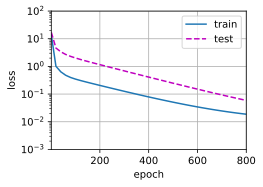

In [18]:
# 三阶多项式函数拟合(正态)
train(poly_features[:n_train,:4],poly_features[n_train:,:4],labels[:n_train],labels[n_train:])  # 最后返回的weight值和公式真实weight值很接近       

weight [[4.0084395 1.9678905]]


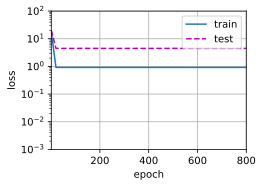

In [19]:
train(poly_features[:n_train,:2],poly_features[n_train:,:2],labels[:n_train],labels[n_train:])

weight [[ 4.9682426   1.4157692  -3.296423    4.5729766   0.5706781   0.9325545
   0.3981409   0.1626032   0.23519318  0.1358412  -0.06549656 -0.04466299
   0.10517506  0.1558361   0.20470874 -0.17934895  0.04416952  0.17300835
   0.17490503 -0.16371816]]


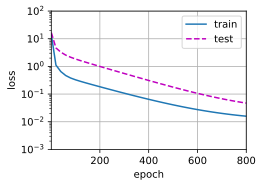

In [20]:
# 十九阶多项式函数拟合(过拟合)
# 这里相当于用十九阶多项式拟合真实的三阶多项式，过拟合了
train(poly_features[:n_train,:],poly_features[n_train:,:],labels[:n_train],labels[n_train:])